#### 📚 Import Libraries 

In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# For image processing
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.exposure import equalize_adapthist
from skimage.filters import gaussian
from skimage.color import rgb2gray
import cv2
# For Model Training
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
# Sklearn utils.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle



In [67]:
TRAIN_DIR = '/Users/ozzy/Desktop/AI for BioMed/CW/aptos2019-blindness-detection/train_images'
TEST_DIR = '/Users/ozzy/Desktop/AI for BioMed/CW/aptos2019-blindness-detection/test_images'
TRAIN_CSV = '/Users/ozzy/Desktop/AI for BioMed/CW/aptos2019-blindness-detection/train.csv'
TEST_CSV = '/Users/ozzy/Desktop/AI for BioMed/CW/aptos2019-blindness-detection/test.csv'

In [68]:
train_labels_df = pd.read_csv(TRAIN_CSV)
test_labels_df = pd.read_csv(TEST_CSV)

### Splitting Data into Training and Test (Validation)

In [69]:
image_ids = train_labels_df['id_code']
diagnosis_labels = train_labels_df['diagnosis']

# Shuffling
image_ids, diagnosis_labels = shuffle(image_ids, diagnosis_labels, random_state=42)

# Splitting
train_ids, valid_ids, train_labels, valid_labels = train_test_split(image_ids, diagnosis_labels, test_size=0.15, stratify=diagnosis_labels, random_state=42)

# Reset index
train_ids.reset_index(drop=True, inplace=True)
valid_ids.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
valid_labels.reset_index(drop=True, inplace=True)

# Print shapes
print("Train IDs:", train_ids.shape)
print("Train Labels:", train_labels.shape)
print("Validation IDs:", valid_ids.shape)
print("Validation Labels:", valid_labels.shape)
print("Test DataFrame Shape:", test_labels_df.shape)


Train IDs: (3112,)
Train Labels: (3112,)
Validation IDs: (550,)
Validation Labels: (550,)
Test DataFrame Shape: (1928, 1)


### Visualising the 👁 Data 

In [35]:
def plot_class_distribution(labels, dataset_type='train'):
    '''
    Improved function to plot and print the distribution of classes.
    '''
    plt.figure(figsize=(8, 6))
    class_counts = labels.value_counts().sort_index()
    class_counts.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Number of Observations')
    plt.title(f'Class Distribution in {dataset_type} Dataset')
    plt.grid(axis='y')

    # Adding percentage annotations on each bar
    total = len(labels)
    for index, value in enumerate(class_counts):
        percentage = f'{(value / total * 100):.2f}%'
        plt.text(index, value, percentage, ha='center')

    plt.show()

    # Print class distribution details
    for class_id, count in class_counts.items():
        percentage = (count / total * 100)
        print(f'Class {class_id}: {count} observations ({percentage:.2f}%)')



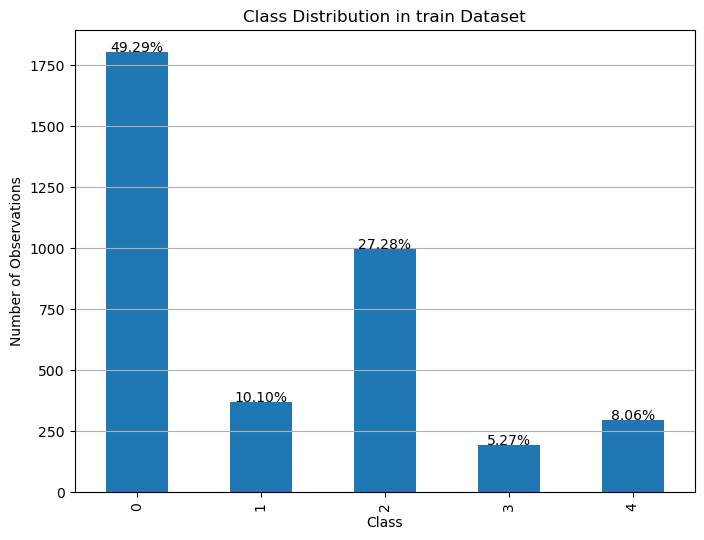

Class 0: 1805 observations (49.29%)
Class 1: 370 observations (10.10%)
Class 2: 999 observations (27.28%)
Class 3: 193 observations (5.27%)
Class 4: 295 observations (8.06%)


In [7]:
plot_class_distribution(train_labels_df['diagnosis'], 'train')


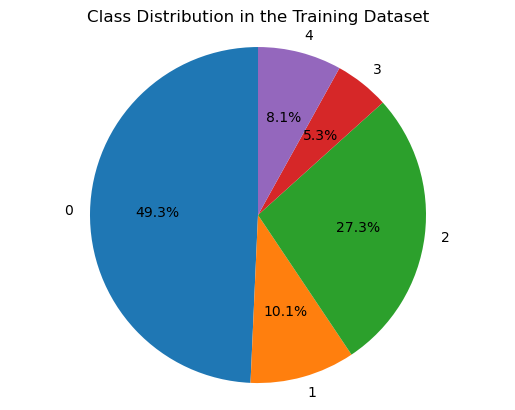

In [75]:

# Data for the classes and their observations
classes = ['0', '1', '2', '3', '4']
observations = [1805, 370, 999, 193, 295]

# Calculate the percentages for each class
total = sum(observations)
percentages = [o / total * 100 for o in observations]

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(percentages, labels=classes, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Add a title
plt.title('Class Distribution in the Training Dataset')

# Display the chart
plt.show()

In [8]:
def display_sample_images(df, img_dir, num_images=5):
    fig, axes = plt.subplots(num_images, len(df['diagnosis'].unique()), figsize=(20, num_images*3))
    for i, diag in enumerate(df['diagnosis'].unique()):
        sample_images = df[df['diagnosis'] == diag].sample(num_images)
        for j in range(num_images):
            img_path = os.path.join(img_dir, sample_images.iloc[j]['id_code'] + '.png')
            image = plt.imread(img_path)
            axes[j, i].imshow(image)
            axes[j, i].axis('off')
            axes[j, i].set_title('Class: {}'.format(diag))
    plt.tight_layout()
    plt.show()


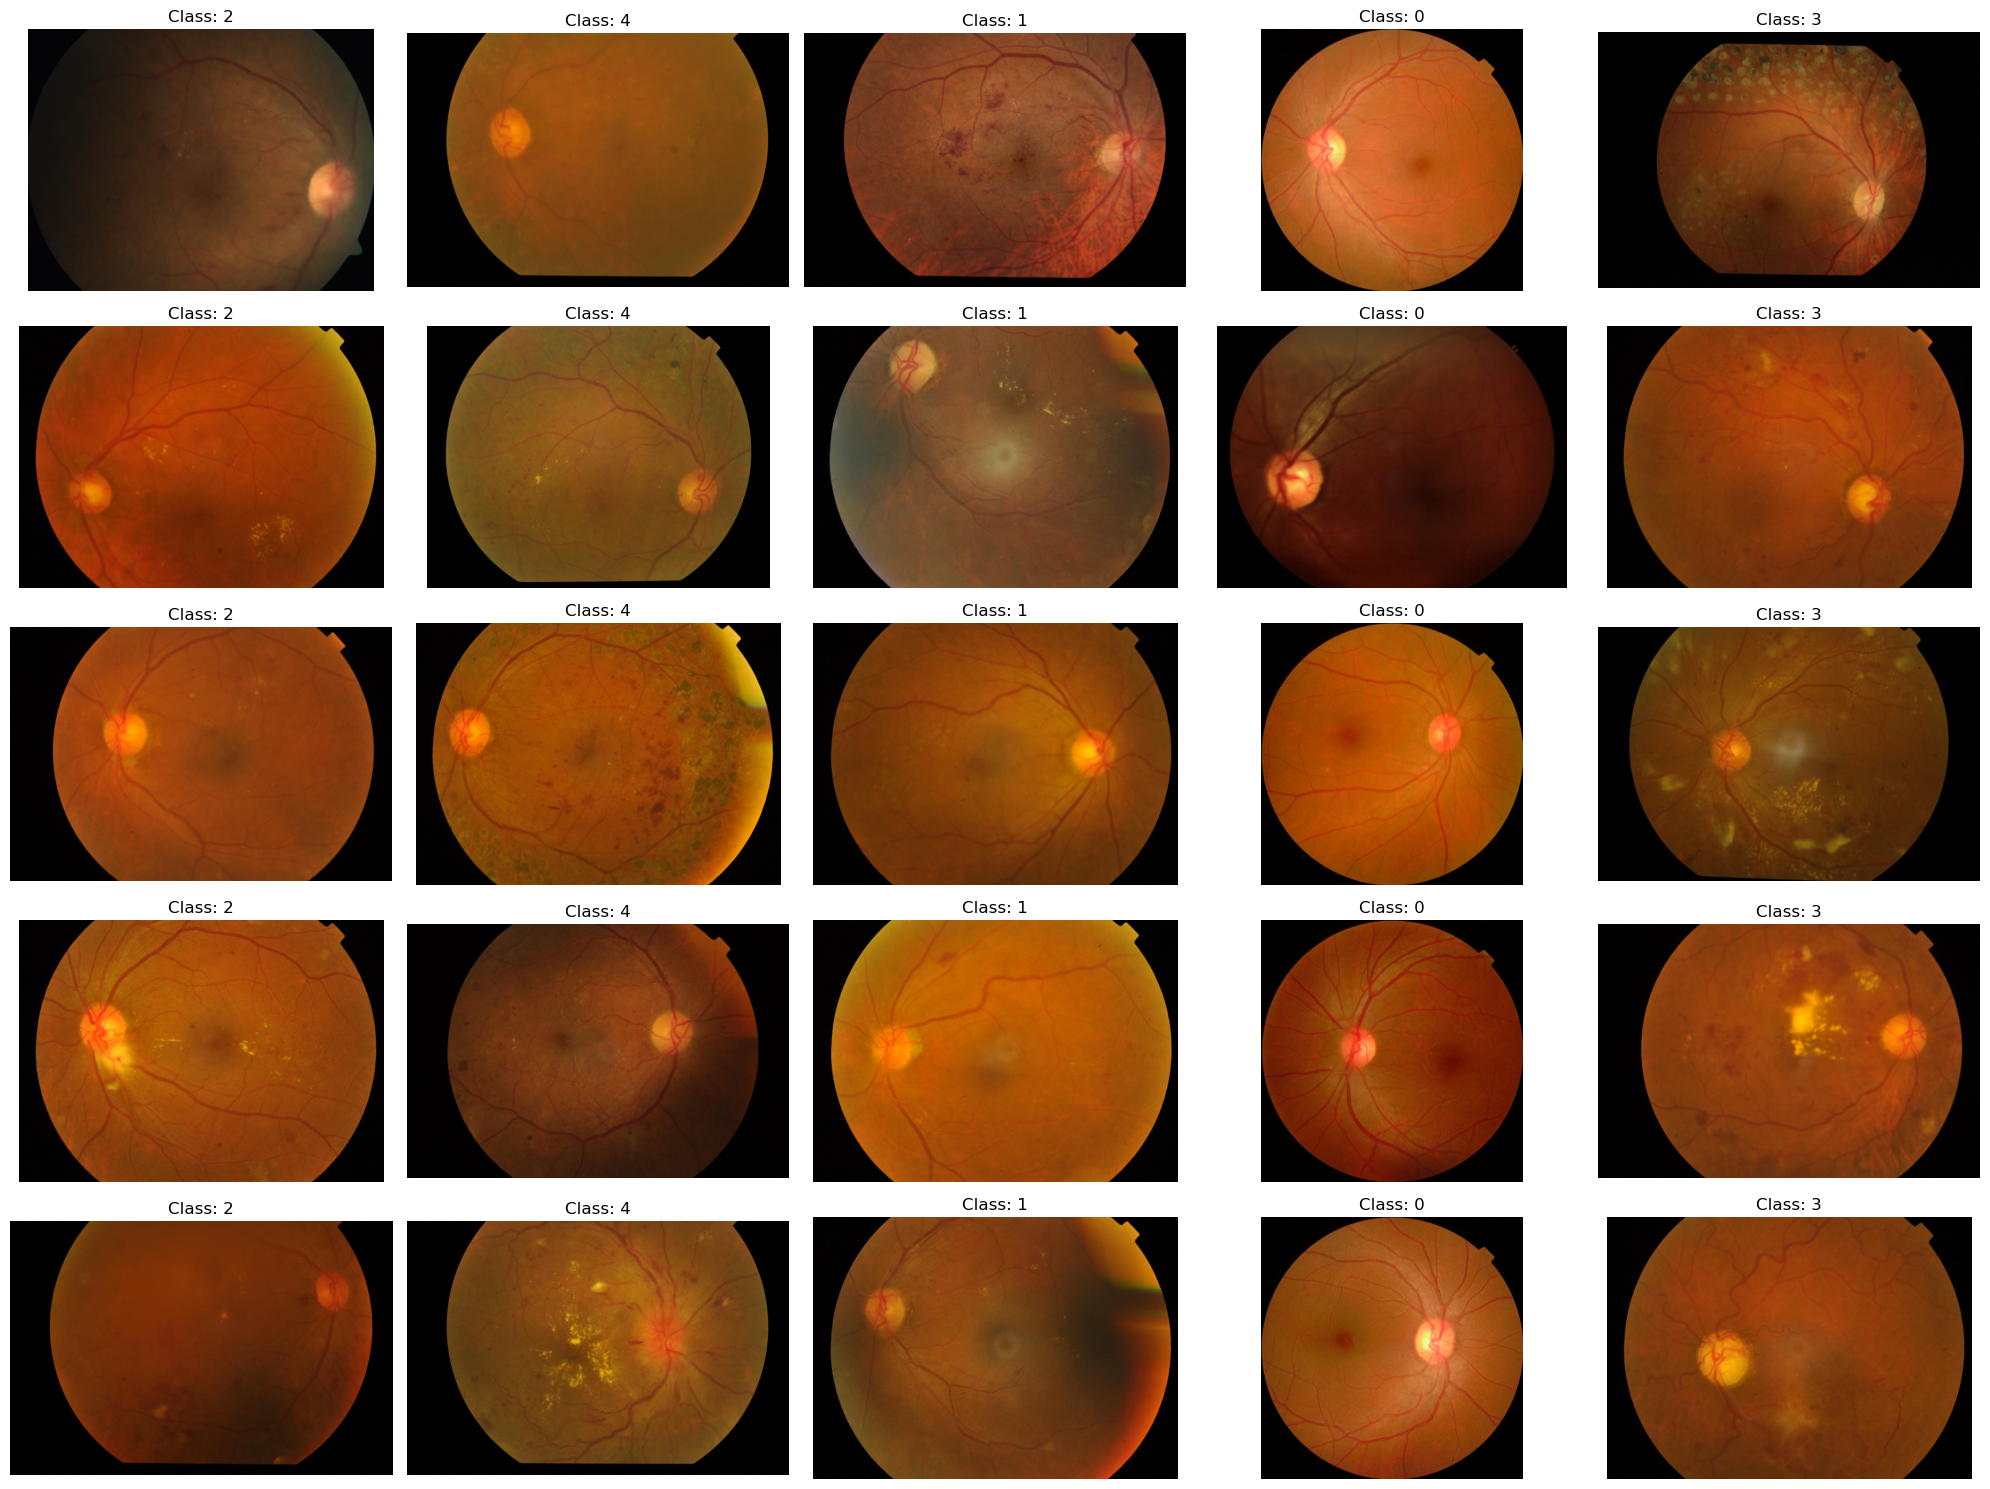

In [9]:
display_sample_images(train_labels_df, TRAIN_DIR, 5)

In [47]:
def analyze_image_properties(df, img_dir):
    brightness = []
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['id_code'] + '.png')
        image = plt.imread(img_path)
        brightness.append(np.mean(image))
    return brightness


In [48]:
# Analyzing the variation in brightness values for a subset of our images
brightness_values = analyze_image_properties(train_labels_df[0:100], TRAIN_DIR)


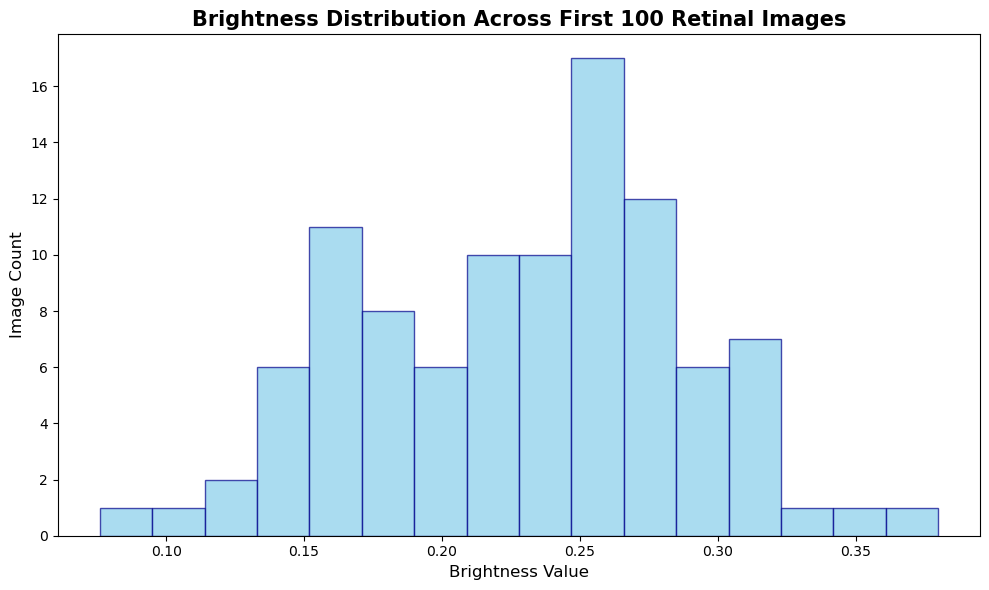

In [53]:

plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=16, color='skyblue', edgecolor='darkblue', alpha=0.7, zorder=2)
plt.title('Brightness Distribution Across First 100 Retinal Images', fontsize=15, fontweight='bold')
plt.xlabel('Brightness Value', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
# plt.grid(True, color='gray', linestyle='--', linewidth=0.5, zorder=1)  # Fine-tune grid behind the histogram
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()



### Preprocessing the Retinal Image Data

In [70]:

def preprocess_image(image_path, target_size=(224, 224)):
    # Load image (as PIL image)
    image = load_img(image_path)
    
    # Resize image
    image = image.resize(target_size)
    
    # Convert image to array and normalize to range [0, 1]
    image = img_to_array(image) / 255.0
    
    # Convert to grayscale to focus on structural features
    image = rgb2gray(image)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    image = equalize_adapthist(image, clip_limit=0.01)
    
    # Apply Gaussian blur to reduce noise
    image = gaussian(image, sigma=1)
    
    # Normalize again after other transformations
    image = (image - image.min()) / (image.max() - image.min())
    
    # Expand dimensions to match the CNN input
    image = np.expand_dims(image, axis=-1)
    
    return image

def preprocess_dataset(image_ids, img_dir, target_size=(224, 224)):
    preprocessed_images = []
    for image_id in image_ids:
        img_path = os.path.join(img_dir, image_id + '.png')
        preprocessed_image = preprocess_image(img_path, target_size)
        preprocessed_images.append(preprocessed_image)
    return np.array(preprocessed_images)




In [43]:
preprocessed_train_images = preprocess_dataset(train_ids, TRAIN_DIR)

In [24]:
def display_processed_images(images_directory, num_images=10):
    # Get the list of image file paths
    image_files = [os.path.join(images_directory, img_file) for img_file in sorted(os.listdir(images_directory)) if img_file.endswith('.png')]
    
    # Set the number of images to display (limited by `num_images` parameter)
    image_files = image_files[:num_images]
    
    # Load the images
    images = [cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) for img_file in image_files]
    
    # Display the images
    plt.figure(figsize=(20, 4 * num_images))
    for i, img in enumerate(images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()



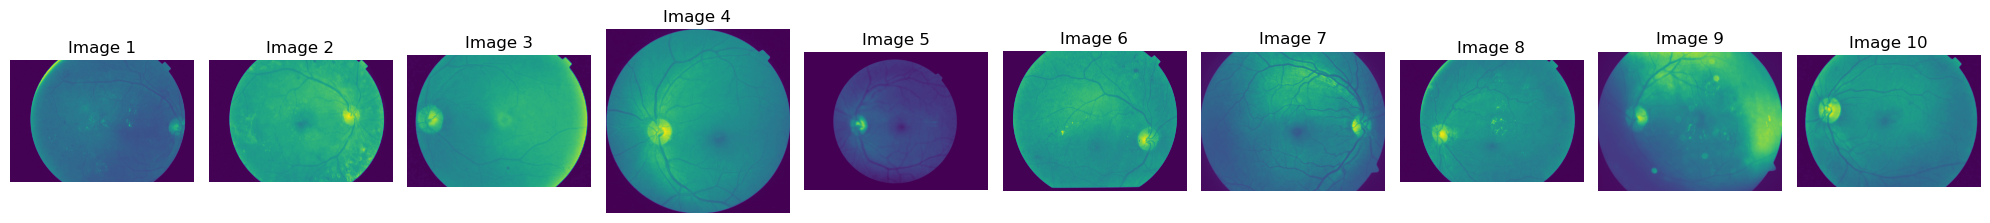

In [25]:
# Call the function with the path to your processed images directory
display_processed_images(TRAIN_DIR)

In [39]:
def save_processed_images_to_disk(preprocessed_images, image_ids, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    # Loop through the preprocessed images and their corresponding IDs
    for img_array, image_id in zip(preprocessed_images, image_ids):
        # Convert the image array back to an image
        img_array = (img_array * 255).astype('uint8')  # Make sure to rescale back to [0,255]
        
        # Generate the full path where the image will be saved
        save_path = os.path.join(target_dir, image_id + '.png')
        
        # Save the image
        # We need to handle both grayscale and color images
        if img_array.shape[-1] == 1:  # Grayscale image, remove single channel for saving
            cv2.imwrite(save_path, img_array[:, :, 0])
        else:  # Color image
            cv2.imwrite(save_path, cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR))






In [ ]:
processed_train_dir = '/Users/ozzy/Desktop/AI for BioMed/CW/aptos2019-blindness-detection/processed_train_images'
save_processed_images_to_disk(preprocessed_train_images, train_ids, processed_train_dir)

In [72]:
# Preprocess the validation images
preprocessed_val_images = preprocess_dataset(valid_ids, TRAIN_DIR)

In [29]:
processed_valid_dir = '/Users/ozzy/Desktop/AI for BioMed/CW/aptos2019-blindness-detection/processed_valid_images'
save_processed_images_to_disk(preprocessed_val_images, valid_ids, processed_valid_dir)

In [39]:

# Create a new input layer that accepts grayscale images
input_tensor = Input(shape=(224, 224, 1))

# Use a Lambda layer to replicate the grayscale image across 3 channels
x = Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(input_tensor)

# Load DenseNet121 with the new input
base_model = DenseNet121(input_tensor=x, include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Define the model
model = Model(inputs=input_tensor, outputs=predictions)

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes=5)
valid_labels_one_hot = to_categorical(valid_labels, num_classes=5)

# Compile the model with categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with one-hot encoded labels
history = model.fit(preprocessed_train_images, train_labels_one_hot, 
                    validation_data=(preprocessed_val_images, valid_labels_one_hot), 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stopping, model_checkpoint])

# Load the best model
model.load_weights('best_model.h5')

# Optionally, you can evaluate the model on your validation set
# val_predictions = model.predict(preprocessed_val_images)
# print("Validation Predictions:", val_predictions)
# TOOK 170 mins to train


Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 0.9087 - accuracy: 0.6754 - auc_5: 0.8941

/Users/ozzy/miniconda3/envs/mv3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 257s 3s/step - loss: 0.9087 - accuracy: 0.6754 - auc_5: 0.8941 - val_loss: 0.6869 - val_accuracy: 0.7655 - val_auc_5: 0.9436
Epoch 2/50
98/98 [==============================] - 253s 3s/step - loss: 0.6767 - accuracy: 0.7542 - auc_5: 0.9436 - val_loss: 0.6276 - val_accuracy: 0.7800 - val_auc_5: 0.9526
Epoch 3/50
98/98 [==============================] - 233s 2s/step - loss: 0.6328 - accuracy: 0.7706 - auc_5: 0.9500 - val_loss: 0.6007 - val_accuracy: 0.7800 - val_auc_5: 0.9553
Epoch 4/50
98/98 [==============================] - 222s 2s/step - loss: 0.5849 - accuracy: 0.7918 - auc_5: 0.9578 - val_loss: 0.5903 - val_accuracy: 0.7745 - val_auc_5: 0.9566
Epoch 5/50
98/98 [==============================] - 224s 2s/step - loss: 0.5601 - accuracy: 0.8001 - auc_5: 0.9611 - val_loss: 0.5744 - val_accuracy: 0.7764 - val_auc_5: 0.9588
Epoch 6/50
98/98 [==============================] - 228s 2s/step - loss: 0.5407 - accuracy: 0.8049 - auc_5: 0.9635 - val_loss:

In [12]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_model.h5')



In [78]:
# Evaluate the model on the test set

# Assuming valid_labels is already defined as your validation labels
valid_labels_one_hot = to_categorical(valid_labels, num_classes=5)

# Then you can evaluate the model
val_loss, val_accuracy, val_auc = model.evaluate(preprocessed_val_images, valid_labels_one_hot)
print(f"Test Loss: {val_loss}")
print(f"Test Accuracy: {val_accuracy}")
print(f"Test AUC: {val_auc}")


18/18 [==============================] - 40s 2s/step - loss: 0.5161 - accuracy: 0.8091 - auc_5: 0.9662
Test Loss: 0.5160752534866333
Test Accuracy: 0.8090909123420715
Test AUC: 0.9662396311759949


### Sample Prediction

18/18 [==============================] - 38s 2s/step - loss: 0.5161 - accuracy: 0.8091 - auc_5: 0.9662
Validation Loss: 0.5160752534866333
Validation Accuracy: 0.8090909123420715
Validation AUC: 0.9662396311759949
1/1 [==============================] - 0s 197ms/step


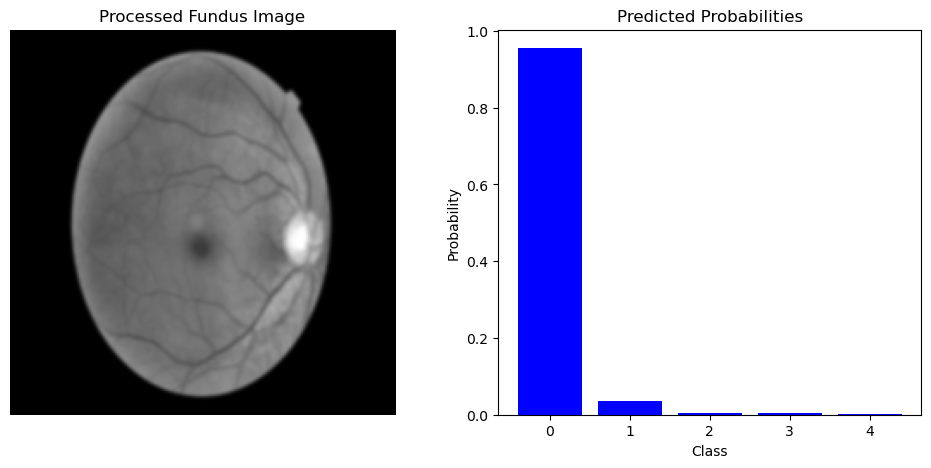

In [73]:

valid_labels_one_hot = to_categorical(valid_labels, num_classes=5)

# Evaluate the model on the validation set
val_loss, val_accuracy, val_auc = model.evaluate(preprocessed_val_images, valid_labels_one_hot)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")

# Predict probabilities for a single image
# Assuming 'index' is the index of the image you want to predict and visualize
index = 0  # replace with the index you want
test_image = preprocessed_val_images[index]
test_label = valid_labels_one_hot[index]
prediction = model.predict(test_image[np.newaxis, ...])[0]

# Plotting the image and probabilities
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Display the image
axes[0].imshow(test_image[..., 0], cmap='gray')  # assuming the image is grayscale
axes[0].set_title('Processed Fundus Image')
axes[0].axis('off')  # Hide the axes ticks

# Display a bar chart of the predictions
axes[1].bar(range(len(prediction)), prediction, color='blue')
axes[1].set_title('Predicted Probabilities')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Probability')
axes[1].set_xticks(range(len(prediction)))
axes[1].set_xticklabels(range(0, 5))  
plt.show()


### Model Test and Evaluation

In [16]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate on the validation set
val_predictions = model.predict(preprocessed_val_images)
print(classification_report(valid_labels, np.argmax(val_predictions, axis=1)))

# Calculate AUC
roc_auc = roc_auc_score(valid_labels, val_predictions, multi_class='ovr')
print("ROC AUC Score:", roc_auc)

18/18 [==============================] - 38s 2s/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       271
           1       0.62      0.64      0.63        56
           2       0.71      0.75      0.73       150
           3       0.41      0.24      0.30        29
           4       0.59      0.50      0.54        44

    accuracy                           0.81       550
   macro avg       0.66      0.62      0.64       550
weighted avg       0.80      0.81      0.80       550

ROC AUC Score: 0.935034055965116


18/18 [==============================] - 36s 2s/step


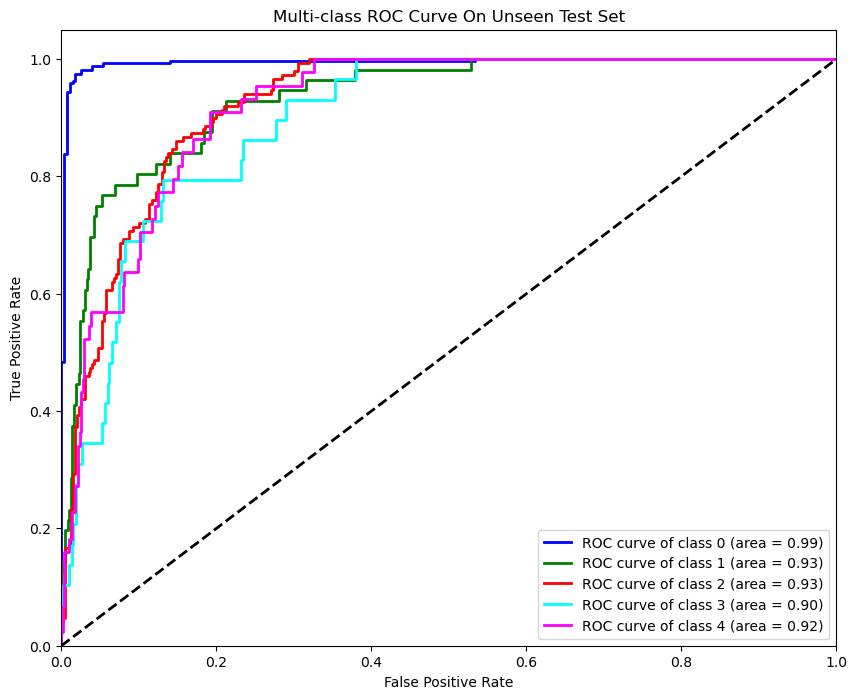

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Get prediction probabilities
y_pred_probs = model.predict(preprocessed_val_images)

# Compute ROC curve and ROC area for each class
n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(valid_labels_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve On Unseen Test Set')
plt.legend(loc="lower right")
plt.show()



18/18 [==============================] - 45s 3s/step


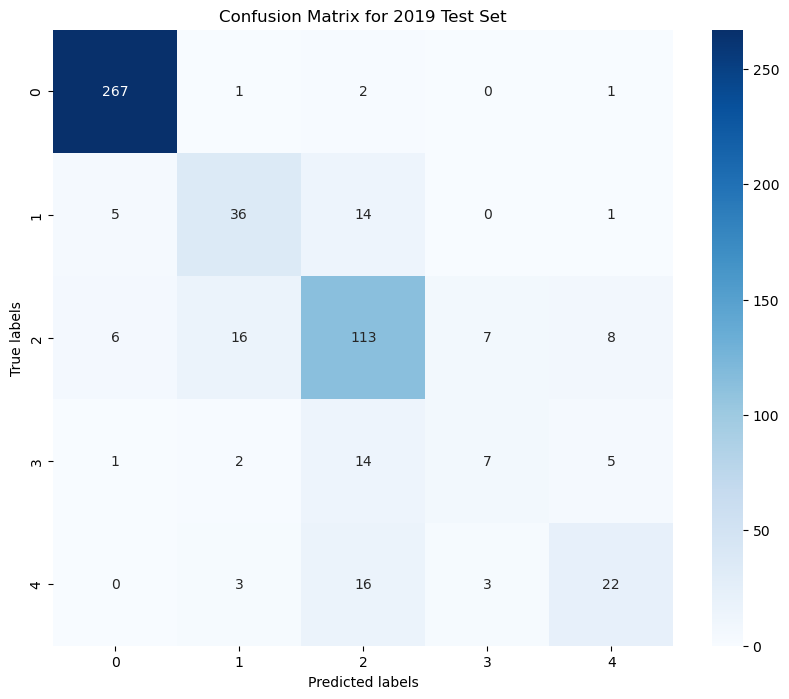

In [76]:
# CONFUSION MATRIX FOR TEST SET
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions on the validation set
val_predictions = model.predict(preprocessed_val_images)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Generate the confusion matrix
conf_matrix_val = confusion_matrix(valid_labels, val_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_val, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for 2019 Test Set')
plt.show()

### Further Experiment - Further Training and Testing on another test set (2015 APTOS Dataset)

In [ ]:
######################## FURTHER TRAINING - UNECESSARY AT THE MOMENT SINCE RESULTS ARE SATISFACTORY ##########################################################
# # Unfreeze some of the top layers of DenseNet121 and continue training
# for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
#     layer.trainable = True

# # Recompile the model (necessary after making changes to layer.trainable)
# model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])

# # Continue training
# history_fine = model.fit(preprocessed_train_images, train_labels, 
#                          validation_data=(preprocessed_val_images, valid_labels), 
#                          epochs=30,  # Number of epochs for fine-tuning
#                          batch_size=32, 
#                          callbacks=[early_stopping, model_checkpoint])

In [28]:
####################### FURTHER EXPERIMENT: NOW TESTING MODEL ON THE 2015 TEST SET (LABELLED) ##############################################
from sklearn.metrics import classification_report, accuracy_score

# Since test images are jpg and not png, we will redefine this function
def preprocess_dataset(image_ids, img_dir, target_size=(224, 224)):
    preprocessed_images = []
    for image_id in image_ids:
        # Change the extension to .jpg
        img_path = os.path.join(img_dir, image_id + '.jpg')
        preprocessed_image = preprocess_image(img_path, target_size)
        preprocessed_images.append(preprocessed_image)
    return np.array(preprocessed_images)

# Load the test labels CSV
test_labels_2015_df = pd.read_csv('/Users/ozzy/Desktop/AI for BioMed/CW/aptos2019-blindness-detection/2015 Labels/testLabels15.csv')

# Randomly sample a subset of images
sampled_test_df = test_labels_2015_df.sample(n=1000, random_state=42)

# Preprocess the sampled images
preprocessed_test_images = preprocess_dataset(sampled_test_df['image'].tolist(), 
                                              '/Users/ozzy/Desktop/AI for BioMed/CW/aptos2019-blindness-detection/2015 Labels/resized test 15')



In [30]:
# Make predictions
predictions = model.predict(preprocessed_test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the predictions
print(classification_report(sampled_test_df['level'].tolist(), predicted_classes))
print("Accuracy:", accuracy_score(sampled_test_df['level'].tolist(), predicted_classes))

32/32 [==============================] - 63s 2s/step
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       728
           1       0.05      0.10      0.07        70
           2       0.20      0.15      0.17       152
           3       0.00      0.00      0.00        24
           4       0.19      0.27      0.22        26

    accuracy                           0.58      1000
   macro avg       0.24      0.25      0.24      1000
weighted avg       0.60      0.58      0.59      1000

Accuracy: 0.579


32/32 [==============================] - 62s 2s/step


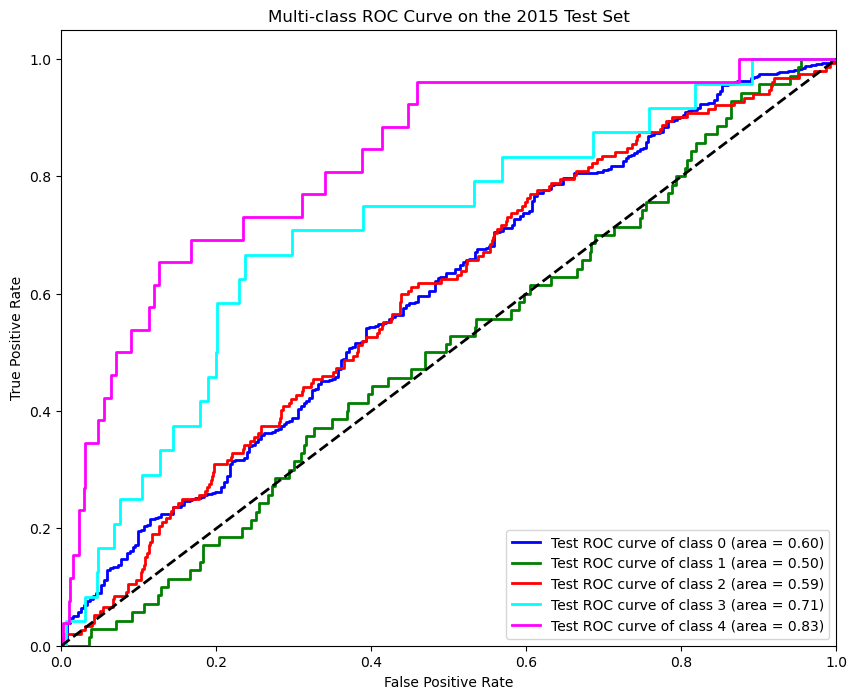

In [31]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from itertools import cycle

# One-hot encode the test labels
test_labels_one_hot = to_categorical(sampled_test_df['level'], num_classes=5)

# Get prediction probabilities for the test set
test_pred_probs = model.predict(preprocessed_test_images)

# Compute ROC curve and ROC area for each class
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(test_labels_one_hot[:, i], test_pred_probs[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot all ROC curves for the test set
plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2,
             label='Test ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_test[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve on the 2015 Test Set')
plt.legend(loc="lower right")
plt.show()


32/32 [==============================] - 65s 2s/step


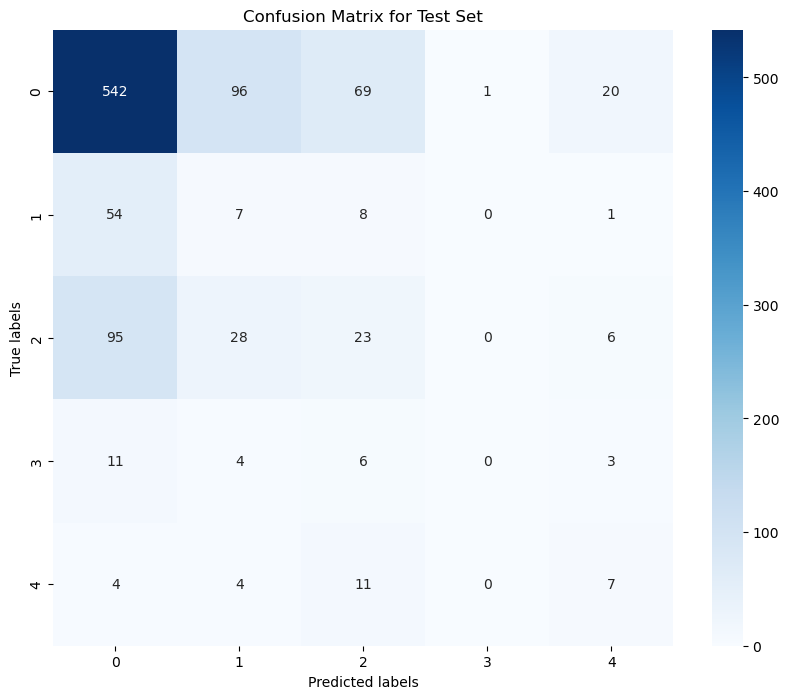

In [33]:
# CONFUSION MATRIX FOR TEST SET
# Predictions on the test set
test_predictions = model.predict(preprocessed_test_images)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Generate the confusion matrix
conf_matrix_test = confusion_matrix(sampled_test_df['level'], test_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test Set')
plt.show()
